We implemented a total of eight classification models for classifying the genres, including Linear Regression, Logistic Regression, Random Forest Classifier, Support Vector Machine, Multi-layer Perceptron Classifier, Gaussian Process Classifier, Gaussian Naive Bayes, and KNN Classifier.

# Import Libraries

In [ ]:
%matplotlib inline
import csv
import librosa
import librosa.display
# import sklearn
import matplotlib.pyplot as plt
import IPython.display as ipd
import os, glob
import pkg_resources
from pkg_resources import DistributionNotFound, VersionConflict
from platform import python_version
import numpy as np
import pandas as pd
import time
import gc
import random
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture

# Load Data
We first loaded the data file saved in the feature extraction step.

In [ ]:
print("reading the data")
data = pd.read_csv('music-data-with-filenames.csv', sep='\t')
data = data.iloc[: , 1:]
headers = list(data.columns)
random_state = 128
data.head()

reading the data


,filepath,filename,genre,beats,tempo,plp,spectrogram,chromagram,tempogram,zero_crossings,zero_crossing_rate,spectral_centroid,spectral_rolloff,spectral_contrast,spectral_bandwidth,spectral_flatness,rms,mfccs
0,data/music-genres-dataset/pop/pop.00027.wav,pop.00027.wav,pop,83.354335,83.354335,0.000000,-4.269063,0.377612,0.127005,67487,0.101867,2682.284141,5956.078988,22.257478,2923.967729,0.047303,0.157902,2.080450
1,data/music-genres-dataset/pop/pop.00033.wav,pop.00033.wav,pop,99.384014,99.384014,0.000000,-3.781867,0.423036,0.158264,90785,0.137010,2835.119375,5944.979313,18.068245,2731.752387,0.061382,0.139896,0.843129
2,data/music-genres-dataset/pop/pop.00032.wav,pop.00032.wav,pop,95.703125,95.703125,0.519045,-4.358516,0.426769,0.121314,151492,0.228641,4225.461049,8483.382577,18.657617,3404.380733,0.125869,0.097861,-0.666234
3,data/music-genres-dataset/pop/pop.00026.wav,pop.00026.wav,pop,75.999540,151.999081,0.000000,-4.899115,0.334962,0.133198,68571,0.103494,2525.591959,5552.801896,23.054193,2848.409561,0.030347,0.195626,2.070004
4,data/music-genres-dataset/pop/pop.00030.wav,pop.00030.wav,pop,95.703125,95.703125,0.472598,0.983008,0.357630,0.140248,98516,0.148679,3070.672741,6653.076965,17.128994,2975.765677,0.075034,0.203093,2.515382


# Preprocess Data
We separated the dataset into the feature columns and the target column, and also removed some unneeded columns. For the training columns, as shown in the table above, the ranges of different features varied a lot. So in order to use a common scale, we performed normalization on the feature columns. We also encoded the target column, converting the genres from strings to integers. Finally, as the last step of the data preparation, we shuffled the dataset and then split the dataset into training data and test data with a ratio of 80% to 20%.

In [ ]:
# get feature columns and normalization
scaler = StandardScaler()
x_data = scaler.fit_transform(np.array(data.loc[:, ~data.columns.isin(["genre", "filepath", "filename"])], dtype = float))

# get target column
y_data = data.loc[:, "genre"]

# remove unneeded columns
file_data = data.loc[:, data.columns.isin(["filepath", "filename"])]

genre_list = pd.unique(y_data)
genre_dict = {}
genre_reverse_dict = {}
for i in range(0, len(genre_list)):
  genre_dict[genre_list[i]] = i
  genre_reverse_dict[i] = genre_list[i]

y_data = y_data.apply(lambda x: genre_dict[x])

x_train, x_test, y_train, y_test, file_train, file_test = train_test_split(x_data, y_data, file_data, test_size=0.30, random_state=random_state, shuffle=True)

# Report Generation Function

In [ ]:
def generateReport(target_column, prediction_column, training_columns, unneeded_columns, classification_type, data_type):
  original_output_filename = classification_type + "-" + data_type + "-original.csv"
  original_genre_column = target_column.apply(lambda x: genre_reverse_dict[x])
  original = pd.concat([pd.DataFrame(unneeded_columns).reset_index(drop=True), pd.DataFrame(original_genre_column).reset_index(drop=True), pd.DataFrame(training_columns)], axis=1)
  original.columns = headers
  original.to_csv(original_output_filename, sep=",", header=True, index=True)

  predict_output_filename = classification_type + "-" + data_type + "-predict.csv"
  predict_genre_column = pd.DataFrame(prediction_column)[0].apply(lambda x: genre_reverse_dict[x])
  predict = pd.concat([pd.DataFrame(unneeded_columns).reset_index(drop=True), pd.DataFrame(predict_genre_column).reset_index(drop=True), pd.DataFrame(training_columns)], axis=1)
  predict.columns = headers
  predict.to_csv(predict_output_filename, sep=",", header=True, index=True)

  report_output_filename = classification_type + "-" + data_type + "-report.csv"
  report = pd.DataFrame(classification_report(target_column, prediction_column, target_names=genre_list, output_dict=True)).to_csv(report_output_filename, sep=",", header=True, index=True)


The model was trained one by one with the exact same training data and test data.

# Linear Regression

In [ ]:
lin_reg = LinearRegression().fit(x_train, y_train)
y_predict_train = lin_reg.predict(x_train)
y_predict_test = lin_reg.predict(x_test)

rounded_predict_train = [round(x) for x in y_predict_train]
train_accuracy = accuracy_score(y_train, rounded_predict_train)
print("Linear Regression Train Accuracy:", train_accuracy)

rounded_predict_test = [round(x) for x in y_predict_test]
for i in range(len(rounded_predict_test)):
  if rounded_predict_test[i] < 0:
    rounded_predict_test[i] = 0
  elif rounded_predict_test[i] > 9:
    rounded_predict_test[i] = 9
# print(list(filter(lambda x : (x < 0) | (x > 9), rounded_predict_test)))
test_accuracy = accuracy_score(y_test, rounded_predict_test)
print("Linear Regression Test Accuracy:", test_accuracy)

# generateReport(y_test, rounded_predict_test, x_test, file_test, "lin_reg", "test")

Linear Regression Train Accuracy: 0.11428571428571428
Linear Regression Test Accuracy: 0.12666666666666668


# Logistic Regression

In [ ]:
log_reg = LogisticRegression(random_state=random_state).fit(x_train, y_train)
y_predict_train = log_reg.predict(x_train)
y_predict_test = log_reg.predict(x_test)

train_accuracy = accuracy_score(y_train, y_predict_train)
print("Logistic Regression Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test, y_predict_test)
print("Logistic Regression Test Accuracy:", test_accuracy)
generateReport(y_test, y_predict_test, x_test, file_test, "log_reg", "test")

Logistic Regression Train Accuracy: 0.6114285714285714
Logistic Regression Test Accuracy: 0.52


# Random Forest Classifier

In [ ]:
rf_clf = RandomForestClassifier(random_state=random_state).fit(x_train, y_train)
y_predict_train = rf_clf.predict(x_train)
y_predict_test = rf_clf.predict(x_test)

train_accuracy = accuracy_score(y_train, y_predict_train)
print("Random Forest Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test, y_predict_test)
print("Random Forest Test Accuracy:", test_accuracy)

# generateReport(y_test, y_predict_test, x_test, file_test, "rf", "test")

Random Forest Train Accuracy: 1.0
Random Forest Test Accuracy: 0.5666666666666667


# Support Vector Machine

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train)
scaled_x_train = scaler.transform(x_train)
scaled_x_test = scaler.transform(x_test)

svm_clf = SVC(gamma='auto').fit(scaled_x_train, y_train)
y_predict_train = svm_clf.predict(scaled_x_train)
y_predict_test = svm_clf.predict(scaled_x_test)

train_accuracy = accuracy_score(y_train, y_predict_train)
print("Support Vector Machine Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test, y_predict_test)
print("Support Vector Machine Test Accuracy:", test_accuracy)

# generateReport(y_test, y_predict_test, x_test, file_test, "svm_clf", "test")

Support Vector Machine Train Accuracy: 0.7071428571428572
Support Vector Machine Test Accuracy: 0.59


# Multi-layer Perceptron Classifier

In [ ]:
mlp = MLPClassifier(random_state=random_state, hidden_layer_sizes=(256,128,64,10), activation='relu', solver='adam', max_iter=10000).fit(x_train,y_train)
y_predict_train = mlp.predict(x_train)
y_predict_test = mlp.predict(x_test)

train_accuracy = accuracy_score(y_train, y_predict_train)
print("Multi-layer Perceptron Classifier Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test, y_predict_test)
print("Multi-layer Perceptron Classifier Test Accuracy:", test_accuracy)

# generateReport(y_test, y_predict_test, x_test, file_test, "mlp", "test")

Multi-layer Perceptron Classifier Train Accuracy: 1.0
Multi-layer Perceptron Classifier Test Accuracy: 0.5433333333333333


# Gaussian Process Classifier

In [ ]:
gpc = GaussianProcessClassifier().fit(x_train,y_train)
y_predict_train = gpc.predict(x_train)
y_predict_test = gpc.predict(x_test)

train_accuracy = accuracy_score(y_train, y_predict_train)
print("Gaussian Process Classifier Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test, y_predict_test)
print("Gaussian Process Classifier Test Accuracy:", test_accuracy)

# generateReport(y_test, y_predict_test, x_test, file_test, "gpc", "test")

Gaussian Process Classifier Train Accuracy: 0.96
Gaussian Process Classifier Test Accuracy: 0.56


# Gaussian Naive Bayes

In [ ]:
gnb = GaussianNB().fit(x_train,y_train)
y_predict_train = gnb.predict(x_train)
y_predict_test = gnb.predict(x_test)

train_accuracy = accuracy_score(y_train, y_predict_train)
print("Gaussian Naive Bayes Classifier Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test, y_predict_test)
print("Gaussian Naive Bayes Classifier Test Accuracy:", test_accuracy)

# generateReport(y_test, y_predict_test, x_test, file_test, "gnb", "test")

Gaussian Naive Bayes Classifier Train Accuracy: 0.4857142857142857
Gaussian Naive Bayes Classifier Test Accuracy: 0.47333333333333333


# KNN Classifier

KNN Classifier Train Accuracy: 0.6685714285714286
KNN Classifier Test Accuracy: 0.53


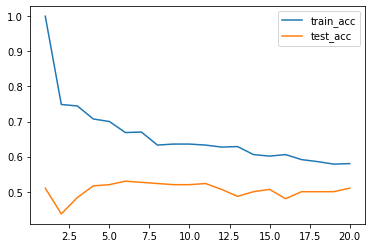

In [ ]:
def knnClassifier(number_of_k):
  knn = KNeighborsClassifier(n_neighbors=number_of_k).fit(x_train,y_train)
  y_predict_train = knn.predict(x_train)
  y_predict_test = knn.predict(x_test)

  train_accuracy = accuracy_score(y_train, y_predict_train)
  # print("KNN Classifier Train Accuracy:", train_accuracy)

  test_accuracy = accuracy_score(y_test, y_predict_test)
  # print("KNN Classifier Test Accuracy:", test_accuracy)

  if(number_of_k == 6):
    print("KNN Classifier Train Accuracy:", train_accuracy)
    print("KNN Classifier Test Accuracy:", test_accuracy)

    # generateReport(y_test, y_predict_test, x_test, file_test, "knn", "test")

  return train_accuracy, test_accuracy

train_acc_list = []
test_acc_list = []
number_of_k_list = []
for i in range(20):
  train_acc, test_acc = knnClassifier(i + 1)
  train_acc_list.append(train_acc)
  test_acc_list.append(test_acc)
  number_of_k_list.append(i + 1)

plt.plot(number_of_k_list, train_acc_list, label = "train_acc")
plt.plot(number_of_k_list, test_acc_list, label = "test_acc")
plt.legend()
plt.show()


Finally, we use the well-trained models to predict 30 unlabeled songs which are provided by ourselves.

# Testing Data Load

In [ ]:
test_data = pd.read_csv('test-data-with-filenames.csv', sep='\t')
test_data = test_data.iloc[: , 1:]
headers = list(test_data.columns)
random_state = 128
test_data.head()

,filepath,filename,genre,beats,tempo,plp,spectrogram,chromagram,tempogram,zero_crossings,zero_crossing_rate,spectral_centroid,spectral_rolloff,spectral_contrast,spectral_bandwidth,spectral_flatness,rms,mfccs
0,data/test-dataset/Song-8.wav,Song-8.wav,UNKNOWN,89.102909,89.102909,0.000000,-16.543032,0.332724,0.117920,41342,0.061539,1510.052503,3030.086872,25.775860,1735.260693,0.012133,0.153569,-6.271770
1,data/test-dataset/Song-9.wav,Song-9.wav,UNKNOWN,161.499023,161.499023,0.000000,-20.206150,0.312816,0.142823,27891,0.042108,1191.686210,2253.855852,28.328128,1759.827555,0.003698,0.112579,-3.528376
2,data/test-dataset/Numb.wav,Numb.wav,UNKNOWN,112.347147,112.347147,0.100649,-3.723843,0.353801,0.179449,83624,0.101963,2329.571324,4824.446869,22.841285,2379.415957,0.023899,0.228743,4.486484
3,data/test-dataset/Song-10.wav,Song-10.wav,UNKNOWN,80.749512,135.999178,0.322571,-28.617315,0.543128,0.178184,7713,0.011733,466.673594,687.799802,22.220836,1060.676634,0.000101,0.144264,3.794124
4,data/test-dataset/Faint.wav,Faint.wav,UNKNOWN,135.999178,135.999178,0.119786,1.106996,0.446038,0.197053,100786,0.148404,2672.091874,5226.400925,21.932053,2449.910507,0.049539,0.236081,1.751070


# Preprocess Testing Data

In [ ]:
# get training columns and normalization
scaler = StandardScaler()
x_test_data = scaler.fit_transform(np.array(test_data.loc[:, ~test_data.columns.isin(["genre", "filepath", "filename"])], dtype = float))

# get target column
y_test_data = test_data.loc[:, "genre"]

# remove unneeded columns
file_test_data = test_data.loc[:, test_data.columns.isin(["filepath", "filename"])]

# Testing Data Prediction

In [ ]:
prediction_results = pd.DataFrame(file_test_data)

# Linear Regression
y_test_data_predict = lin_reg.predict(x_test_data)
y_test_data_predict = [round(x) for x in y_test_data_predict]
for i in range(len(y_test_data_predict)):
  if y_test_data_predict[i] < 0:
    y_test_data_predict[i] = 0
  elif y_test_data_predict[i] > 9:
    y_test_data_predict[i] = 9
lin_reg_prediction_results = pd.DataFrame(pd.DataFrame(y_test_data_predict)[0].apply(lambda x: genre_reverse_dict[x]))
lin_reg_prediction_results.columns = ["linear_regression"]
prediction_results = pd.concat([prediction_results, lin_reg_prediction_results], axis=1)

# Logistic Regression
y_test_data_predict = log_reg.predict(x_test_data)
log_reg_prediction_results = pd.DataFrame(pd.DataFrame(y_test_data_predict)[0].apply(lambda x: genre_reverse_dict[x]))
log_reg_prediction_results.columns = ["logistic_regression"]
prediction_results = pd.concat([prediction_results, log_reg_prediction_results], axis=1)

# Random Forest
y_test_data_predict = rf_clf.predict(x_test_data)
rf_prediction_results = pd.DataFrame(pd.DataFrame(y_test_data_predict)[0].apply(lambda x: genre_reverse_dict[x]))
rf_prediction_results.columns = ["random_forest"]
prediction_results = pd.concat([prediction_results, rf_prediction_results], axis=1)

# SVM
scaler = StandardScaler()
scaler.fit(x_train)
scaled_x_test_data = scaler.transform(x_test_data)
y_test_data_predict = svm_clf.predict(scaled_x_test_data)
svm_prediction_results = pd.DataFrame(pd.DataFrame(y_test_data_predict)[0].apply(lambda x: genre_reverse_dict[x]))
svm_prediction_results.columns = ["svm"]
prediction_results = pd.concat([prediction_results, svm_prediction_results], axis=1)

# Multi-layer Perceptron
y_test_data_predict = mlp.predict(x_test_data)
mlp_prediction_results = pd.DataFrame(pd.DataFrame(y_test_data_predict)[0].apply(lambda x: genre_reverse_dict[x]))
mlp_prediction_results.columns = ["multi-layer_perceptron"]
prediction_results = pd.concat([prediction_results, mlp_prediction_results], axis=1)

# Gaussian Process
y_test_data_predict = gpc.predict(x_test_data)
gpc_prediction_results = pd.DataFrame(pd.DataFrame(y_test_data_predict)[0].apply(lambda x: genre_reverse_dict[x]))
gpc_prediction_results.columns = ["gaussian_process"]
prediction_results = pd.concat([prediction_results, gpc_prediction_results], axis=1)

# Gaussian Naive Bayes
y_test_data_predict = gnb.predict(x_test_data)
gnb_prediction_results = pd.DataFrame(pd.DataFrame(y_test_data_predict)[0].apply(lambda x: genre_reverse_dict[x]))
gnb_prediction_results.columns = ["gaussian_naive_bayes"]
prediction_results = pd.concat([prediction_results, gnb_prediction_results], axis=1)

# KNN
knn = KNeighborsClassifier(6).fit(x_train, y_train)
y_test_data_predict = knn.predict(x_test_data)
knn_prediction_results = pd.DataFrame(pd.DataFrame(y_test_data_predict)[0].apply(lambda x: genre_reverse_dict[x]))
knn_prediction_results.columns = ["knn"]
prediction_results = pd.concat([prediction_results, knn_prediction_results], axis=1)

training_cols = pd.DataFrame(x_test_data)
training_cols_headers = headers[3:]
training_cols.columns = training_cols_headers
prediction_results = pd.concat([prediction_results, training_cols], axis=1)
prediction_results.to_csv("test-data-prediction-results.csv", sep=",", header=True, index=True)